In [1]:
# Uncomment and run if installation does not exist in environment
#%pip install numpy
#%pip install pandas
#%pip install nibabel
#%pip install seaborn
#%pip install matplotlib
#%pip install nilearn
#%pip install pyrelimri

In [20]:
import sys
import os
import argparse
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import image, masking, plotting
from glob import glob
from pyrelimri import similarity
from itertools import product
from scipy.ndimage import binary_erosion
warnings.filterwarnings("ignore")

In [61]:
def extract_median(img_list, mask_img):
    data_list = []
    mask_name = os.path.basename(mask_img)
    mask = mask_name.split('.')[0]
    for img in img_list:
        base_name = os.path.basename(img)
        con, mni, motion, model, fwhm = base_name.split('_')[2:7]
    
        # get median value
        nifti_img = image.load_img(img)
        masked_data = masking.apply_mask(nifti_img, mask_img)
        median_est = np.round(np.median(masked_data), 3)
        
        data_list.append({
            'mask': mask,
            'con': con,
            'motion': motion,
            'model': model,
            'fwhm': fwhm,
            'median_est': median_est
        })
    return pd.DataFrame(data_list)

def file_exists(file_path):
    return os.path.exists(file_path)

# if file doesnt exist, extract media and create file, otherwise load file 
def process_dataset(imgs, mask, out_file):
    if not file_exists(out_file):
        print(f'file {out_file} doesnt exist, creating')
        df = extract_median(imgs, mask)
        df.to_csv(out_file, sep='\t', index=False)
    else:
        print(f'Loading existing {out_file}')
        df = pd.read_csv(out_file, sep='\t')
    return df

def mean_sd_img(list_imgs):
    # get data and stack it
    img_list = [image.load_img(img_path) for img_path in list_imgs]
    img_data = np.stack([img.get_fdata() for img in img_list], axis=-1)
    # calculate the mean + sd image
    mean_img_data = np.mean(img_data, axis=-1)
    sd_img_data = np.std(img_data, axis=-1)
    # convert back into space of icc imgs
    icc_mean_img = image.new_img_like(img_list[0], mean_img_data)
    icc_sd_img = image.new_img_like(img_list[0], sd_img_data)
    # return mean + sd img
    return icc_mean_img,icc_sd_img

def plot_icc_maps(maps, names, coordinates, vmax):
    num_maps = len(maps)
    num_rows = num_maps // 2 + num_maps % 2  # Calculate the number of rows based on the number of maps
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 12))

    for i, map_type in enumerate(maps):
        labels = names[i].split('_')
        est_lab = labels[1]
        #thresh_lab = labels[2]

        row = i // 2
        col = i % 2
        
        if num_rows == 1:  # If only one row, axes is not 2D
            plotting.plot_stat_map(map_type, display_mode='tiled', title=f'{est_lab}',
                                   cut_coords=coordinates, vmax=vmax, axes=axes[col])
        else:
            plotting.plot_stat_map(map_type, display_mode='tiled', title=f'{est_lab}',
                                   cut_coords=coordinates, vmax=vmax, axes=axes[row, col])


    plt.tight_layout()
    plt.show()


def plot_top_maps(imgs, img_index, coordinates, vmax):
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))

    for i, img in enumerate(imgs):
        plotting.plot_stat_map(img[img_index], display_mode='tiled',
                               cut_coords=coordinates, vmax=vmax, axes=axes[i])
    
    plt.tight_layout()
    plt.show()
    
def plot_dist_imgs(imgs, img_index, mask_supra, mask_sub, 
                   bins=500, ylim=(0, 1), xlim=(-5, 50), dec_round=1, xlab=''):
    masked_supra_data = masking.apply_mask(imgs[img_index], mask_supra)
    masked_sub_data = masking.apply_mask(imgs[img_index], mask_sub)

    # median for plots
    med_supra = np.median(masked_supra_data)
    med_sub = np.median(masked_sub_data)

    # Plot the distribution
    plt.hist(np.round(masked_supra_data, decimals=dec_round), bins=bins, edgecolor='black', color='black',
             alpha=1, label='supra-thresh', density=True)  # supra-threshold mask
    plt.hist(np.round(masked_sub_data, decimals=dec_round), bins=bins, edgecolor='black', color='yellow',
             alpha=0.6, label='sub-thresh', density=True)  # sub-threshold mask

    plt.axvline(med_supra, color='red', linestyle='dashed', linewidth=1, label='Median supra-thresh')
    plt.axvline(med_sub, color='blue', linestyle='dashed', linewidth=1, label='Median sub-thresh')
    plt.ylim(ylim[0], ylim[1])
    plt.xlim(xlim[0], xlim[1])

    plt.xlabel(f'{xlab}')
    plt.ylabel('Density')

    plt.legend()
    plt.show()

# Set Study/File info

In [36]:
sample='abcd' # sample, AHRB, MLS or abcd
calc_type='run' # session or run 
ses='baselineYear1Arm1' # abcd opt: baselineYear1Arm1/2YearFollowUpYArm1, MLS/AHRB opts: 1/2

In [37]:
# Set paths
if sample == 'abcd':
    data_path=f'/scratch.global/mdemiden/analyses_reliability'
    out_dir=f'{data_path}'
    icc_est=f'{out_dir}/icc_mods/{calc_type}'
    group_out=f'{out_dir}/group_lowmotion'
    file_out=f'{out_dir}/file_output'
    analysis_path='/home/faird/mdemiden/analyses/reliability/Multiverse_Reliability/Stage2_Code/cluster_jobs'
    subj_list=f'{analysis_path}/subj_ids/mfd_incl.tsv'
elif sample in ['AHRB','MLS']:
    data_path=f'/oak/stanford/groups/russpold/data/{sample}'
    out_dir=f'{data_path}/derivatives/analyses/proj_reliability'
    icc_est=f'{out_dir}/icc_mods/{calc_type}'
    group_out=f'{out_dir}/group'
    analysis_path=f'{data_path}/code/proj_reliability/Multiverse_Reliability/Stage2_Code/cluster_jobs'
else:
    print('Incorrect sample provided. Options: abcd, AHRB, MLS')
    

In [4]:
# load ICC images
# icc 
icc_imgs = sorted(glob(f'{icc_est}/*stat-est.nii.gz'))
#icc_sub_imgs = sorted(glob(f'{icc_est}/*wilson-sub_*stat-est.nii.gz'))
# msbs 
bs_imgs = sorted(glob(f'{icc_est}/*stat-msbtwn.nii.gz'))
#bs_sub_imgs = sorted(glob(f'{icc_est}/*wilson-sub_*stat-msbtwn.nii.gz'))
# msws
ws_imgs = sorted(glob(f'{icc_est}/*stat-mswthn.nii.gz'))
#ws_sub_imgs = sorted(glob(f'{icc_est}/*wilson-sub_*stat-mswthn.nii.gz'))

print("Acquired lists:",
      len(icc_imgs),len(bs_imgs),len(ws_imgs))

Acquired lists: 240 240 240


In [39]:
# load sub and supra masks
mask_supra = f'{analysis_path}/../brain_mask/MNI152_wilson-supra.nii.gz'
mask_sub = f'{analysis_path}/../brain_mask//MNI152_wilson-sub.nii.gz'

In [6]:
# icc
out_icc_supra = f'{file_out}/sample-{sample}_type-{calc_type}_stats-est_mask-wilson-supra.tsv'
out_icc_sub = f'{file_out}/sample-{sample}_type-{calc_type}_stats-est_mask-wilson-sub.tsv'
# msbs
out_bs_supra = f'{file_out}/sample-{sample}_type-{calc_type}_stats-bs_mask-wilson-supra.tsv'
out_bs_sub = f'{file_out}/sample-{sample}_type-{calc_type}_stats-bs_mask-wilson-sub.tsv'
# msw
out_ws_supra = f'{file_out}/sample-{sample}_type-{calc_type}_stats-ws_mask-wilson-supra.tsv'
out_ws_sub = f'{file_out}/sample-{sample}_type-{calc_type}_stats-ws_mask-wilson-sub.tsv'
# similarity
out_similarity= f'{file_out}/sample-{sample}_type-{calc_type}_stats-similarity.tsv'

## Calc concatenated df for model efficiences (motion, parameteization)

In [111]:
# Model permutations
if sample in ['abcd', 'AHRB']:
    voxel = 2.4
    opts = np.array([1.5,  2, 2.5, 3, 3.5])
    fwhm_opt = list(np.round(voxel * opts, 1))
elif sample in 'MLS':
    voxel = 4
    inh_smooth_weight = .50
    opts = np.array([1.5, 2, 2.5, 3, 3.5])*inh_smooth_weight
    fwhm_opt = list(np.round(voxel * opts, 1))

# only including 4; opt 5 is opt3 + subj mFD < .9 & opt6 is opt4 + subj mFD < .9. 
motion_opt = ["opt1", "opt2", "opt3", "opt4"]
modtype_opt = ["CueMod", "AntMod", "FixMod"]

permutation_list = list(product(fwhm_opt, motion_opt, modtype_opt))

In [118]:
ses="baselineYear1Arm1"
first_path = f'{out_dir}/firstlvl/ses-{ses}'
with open(subj_list, 'r') as file:
    directories = [line.strip() for line in file.readlines()]
print(f'subjects: {len(directories)}')

subjects: 130


In [121]:
run = ['1','2']
task = 'MID'
df_eff = []
n = 0
for subject in directories:
    # check and skip subjs w/o acompcor: 
    acomp_patt = f'{first_path}/{subject}/{subject}_ses-{ses}_task-{task}_*mot-opt3*beta.nii.gz'
    n_acompcor = glob(acomp_patt)
    if len(n_acompcor) == 0:
        n=n+1
        print(f'{n}. {subject} bad acompcor, skipping')
    else:
        df_r1 = pd.read_csv(f'{first_path}/{subject}/{subject}_ses-{ses}_task-{task}_run-0{run[0]}_efficiency.tsv', sep=',')
        df_r2 = pd.read_csv(f'{first_path}/{subject}/{subject}_ses-{ses}_task-{task}_run-0{run[1]}_efficiency.tsv', sep=',')
        for i, column_name in enumerate(['fwhm', 'motion', 'model']):
            df_r1[column_name] = [item[i] for item in permutation_list]
            df_r2[column_name] = [item[i] for item in permutation_list]
            
        df_r1.drop_duplicates(subset=['model', 'motion'], inplace=True)
        df_r2.drop_duplicates(subset=['model', 'motion'], inplace=True)
        df_concatenated = pd.concat([df_r1, df_r2])
        df_average = df_concatenated.groupby(['model', 'motion']).mean().reset_index()
        df_average = df_average.drop(['run', 'fwhm'], axis=1)
        df_average['subject'] = subject
        
        df_eff.append(df_average)
    
df_eff = pd.concat(df_eff, ignore_index=True)

1. sub-NDARINV19YE2JCZ bad acompcor, skipping
2. sub-NDARINV1LW4GJ4L bad acompcor, skipping
3. sub-NDARINV4BAX2G31 bad acompcor, skipping
4. sub-NDARINV6D552CRB bad acompcor, skipping
5. sub-NDARINV7WTD2B6V bad acompcor, skipping
6. sub-NDARINVGEMRDDWL bad acompcor, skipping
7. sub-NDARINVCR43W7MR bad acompcor, skipping
8. sub-NDARINVB8234KWV bad acompcor, skipping
9. sub-NDARINVE9W5ZGMN bad acompcor, skipping
10. sub-NDARINVKFUY5YHC bad acompcor, skipping
11. sub-NDARINVF7E957WL bad acompcor, skipping
12. sub-NDARINVL5EAF5N9 bad acompcor, skipping
13. sub-NDARINVNMHULM8G bad acompcor, skipping
14. sub-NDARINVU3ZRYH6G bad acompcor, skipping


In [122]:
columns_to_melt = ["Lgain-Neut", "Sgain-Neut", "Lgain-Base", "Sgain-Base"]

# convert wide to long format
df_eff_lg = pd.melt(df_eff, id_vars=['subject', 'model', 'motion'], 
                      value_vars=columns_to_melt, var_name='con', value_name='eff_est')

# efficiency 
if not os.path.exists(file_out):
    os.makedirs(file_out)
    
out_efficiency= f'{file_out}/sample-{sample}_ses-{ses}_stats-efficiency.tsv'
df_eff_lg.to_csv(out_efficiency, sep='\t', index=False)

# Means and Stand Dev of Estimates

For Aim 1 (ICC estimate) and Aim 2 (Mean Square Between Subject and Within Subject Variance), stated would include:

"First, voxel-wise average and standard deviation from the resulting ICCs for the 360 model permutations are reported in two 3D volumes."

Selected coordinated (L) Ventral Striatum based on Neurosynth search term "ventral striatum" threshold > 20

## ICC est

In [11]:
icc_mean, icc_sd = mean_sd_img(icc_imgs)
#icc_mean_sub, icc_sd_sub = mean_sd_img(icc_sub_imgs)

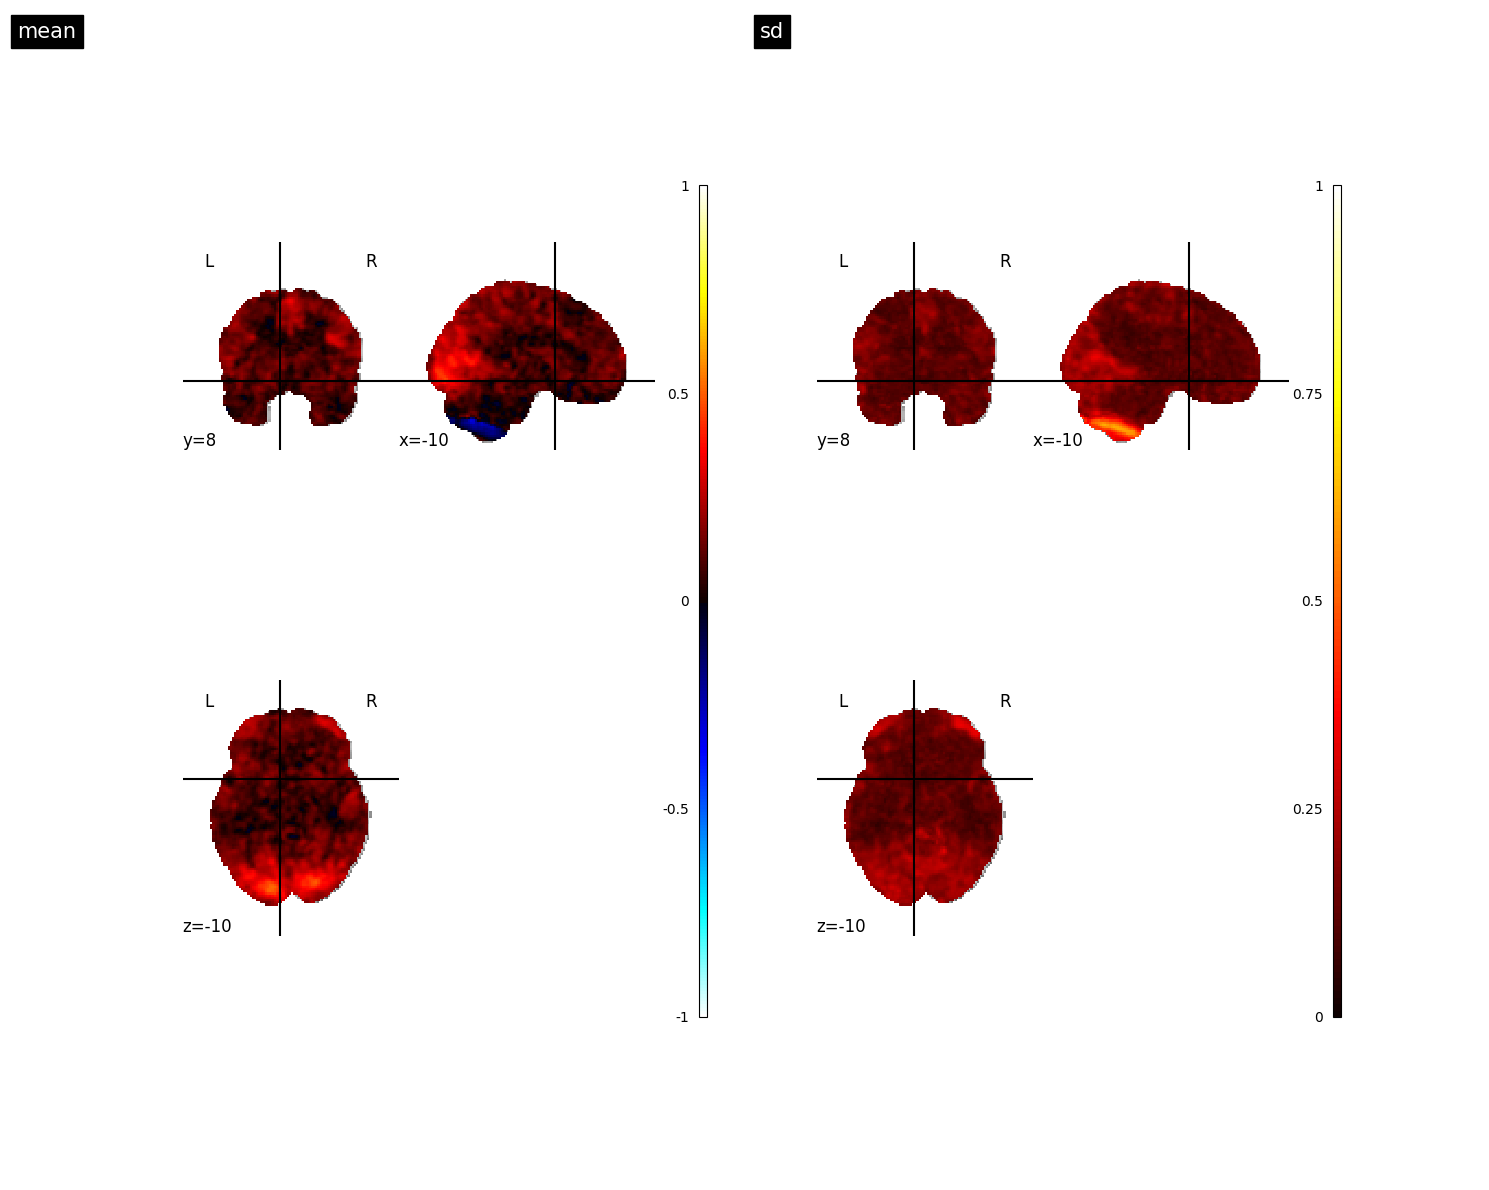

In [25]:
icc_maps = [icc_mean, icc_sd]
icc_names = ['icc_mean', 'icc_sd']

plot_icc_maps(maps=icc_maps, names=icc_names, 
              coordinates=(-10, 8, -10),vmax=1)

## MSBS est

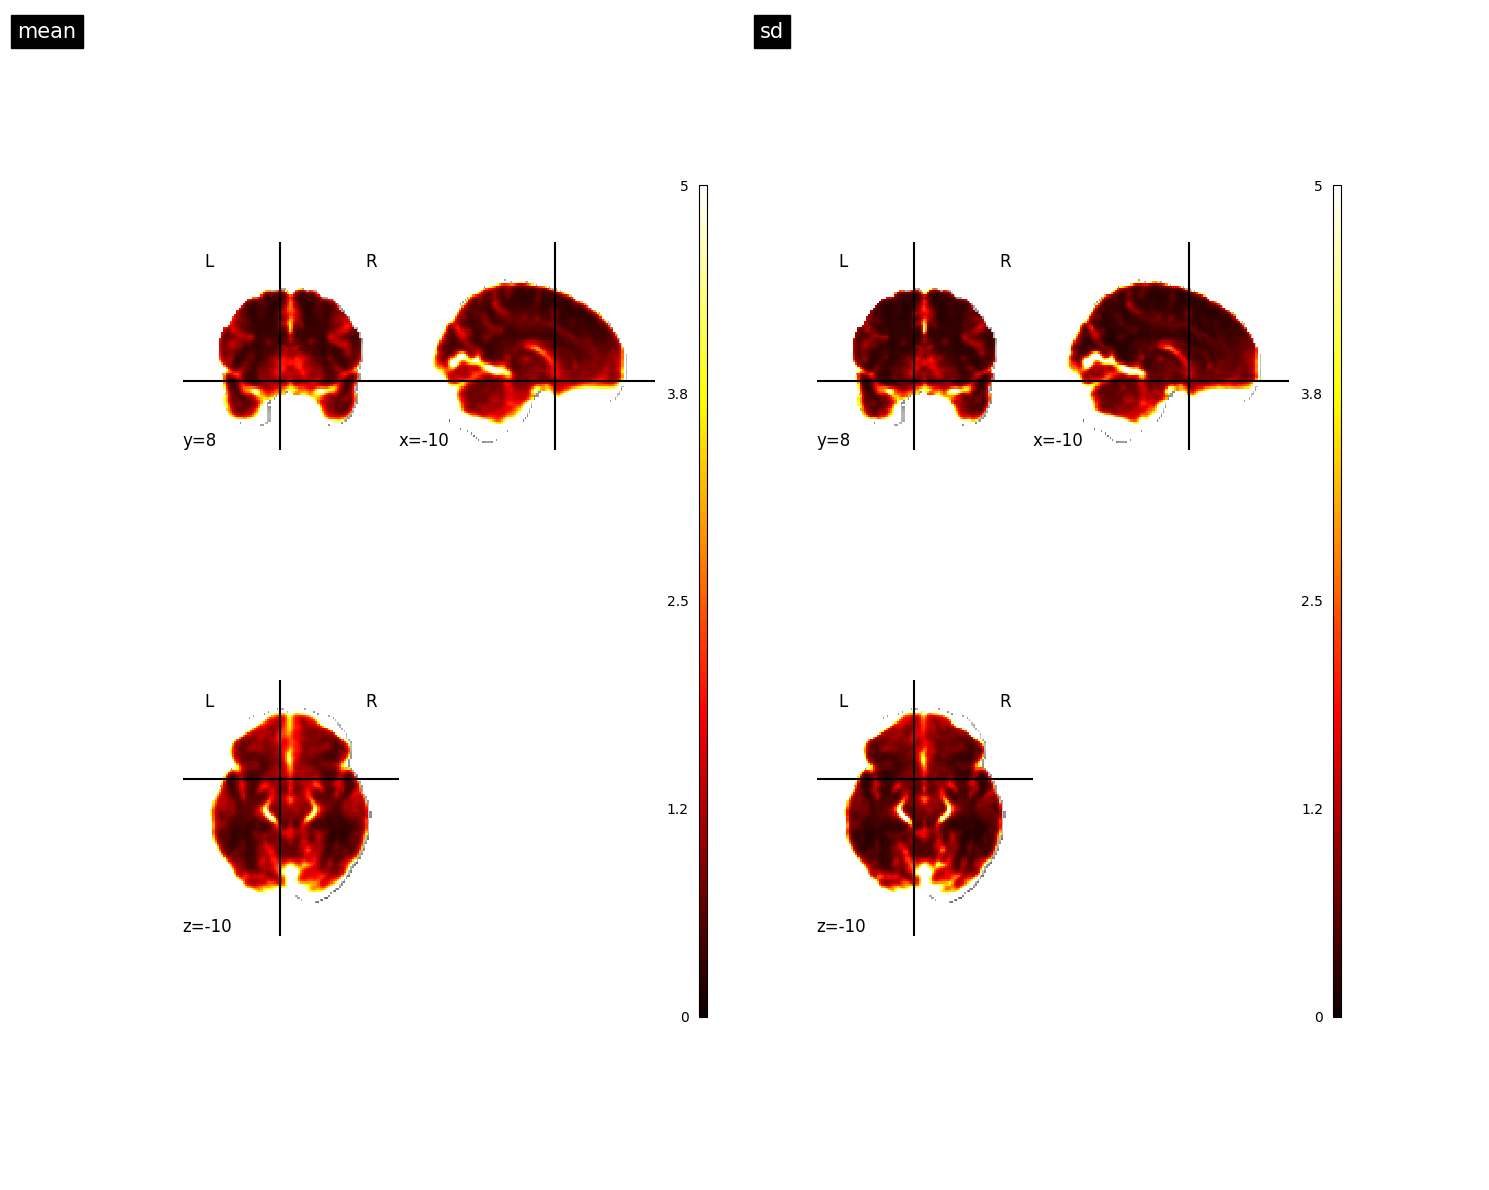

In [27]:
bs_maps = [bs_mean, bs_sd]
bs_names = ['bs_mean', 'bs_sd']

plot_icc_maps(maps=bs_maps, names=bs_names, 
              coordinates=(-10, 8, -10),vmax=5)

## MSWS est

In [29]:
ws_mean, ws_sd = mean_sd_img(ws_imgs)

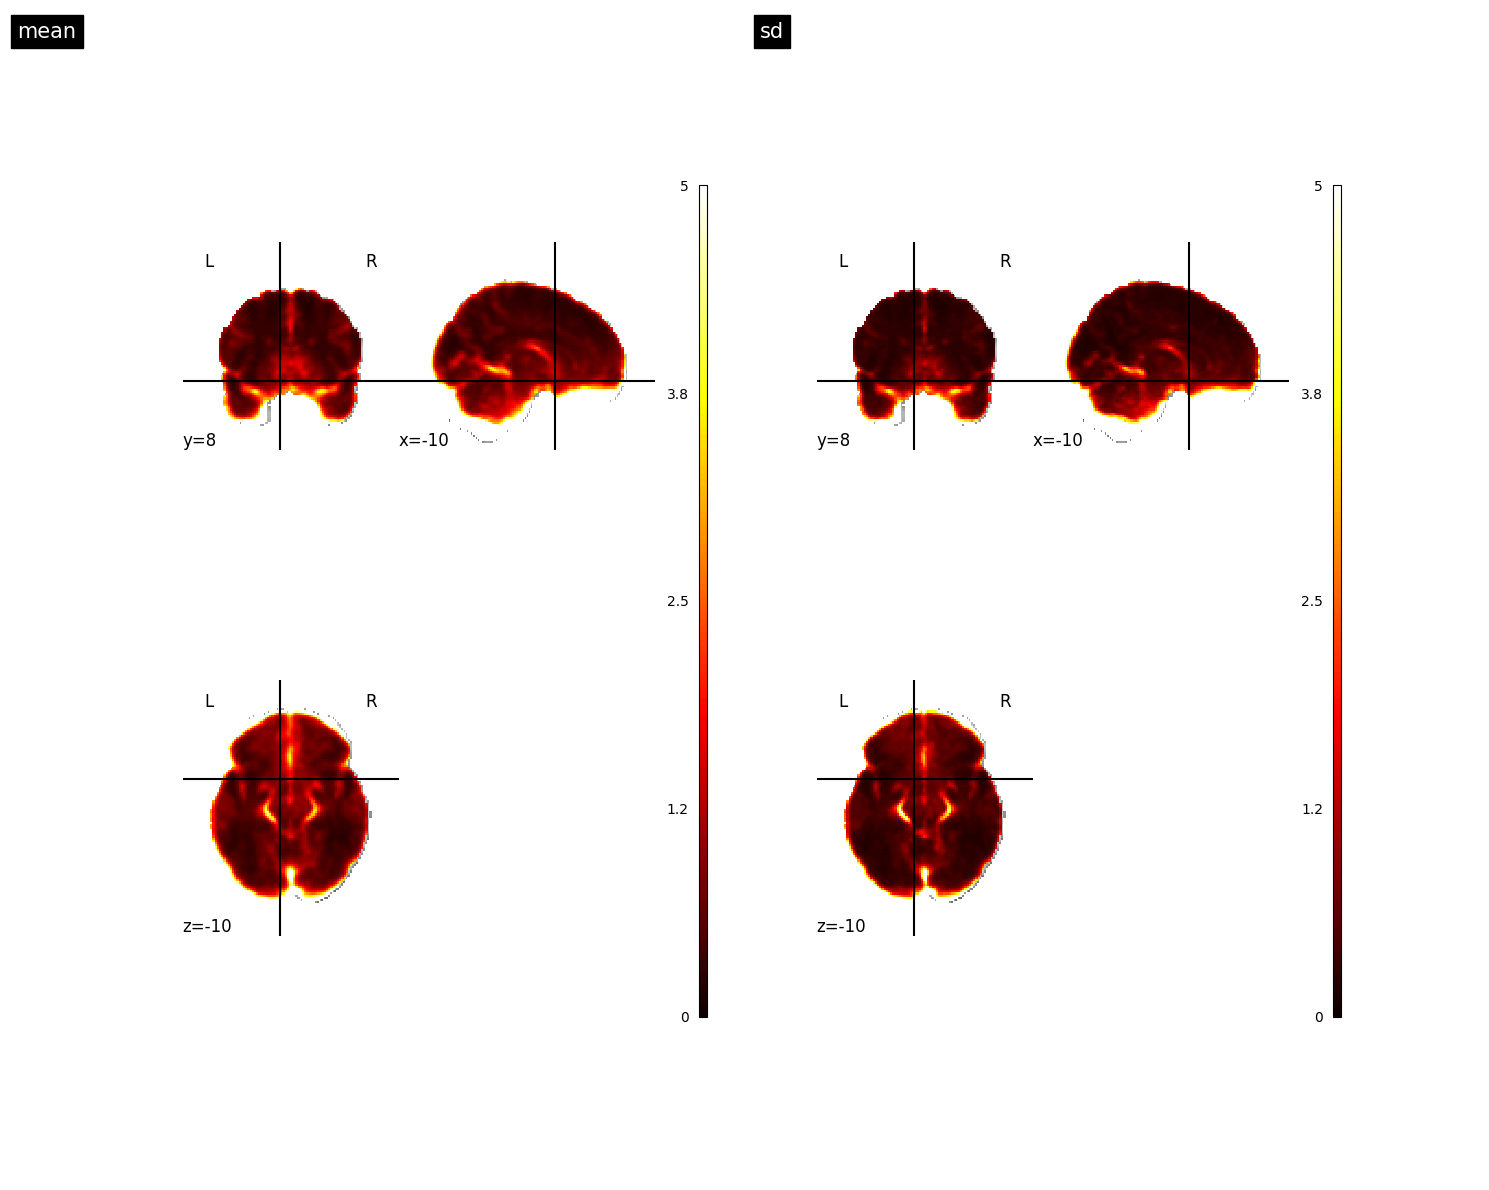

In [33]:
ws_maps = [ws_mean, ws_sd]
ws_names = ['ws_mean', 'ws_sd']

plot_icc_maps(maps=ws_maps, names=ws_names, 
              coordinates=(-10, 8, -10),vmax=5)

# Loading files, Extracting median ICC and providing distribution

For Aim 1 and Aim 2 state would include:
"Second, the range and distribution of median ICCs across each study (three) and analytic decision category (four) are plotted across suprathreshold task-positive and subthreshold ICCs using Rainclouds (Allen et al., 2019) and the median and standard deviation is reported in a table."

While included here to rank and contain some information, plots will be created in R using raincloud features that are more powerful

In [ ]:
# icc datasets
df_icc_supra = process_dataset(icc_imgs, mask_supra, out_icc_supra)
df_icc_sub = process_dataset(icc_imgs, mask_sub, out_icc_sub)

# msbs datasets
df_bs_supra = process_dataset(bs_imgs, mask_supra, out_bs_supra)
df_bs_sub = process_dataset(bs_imgs, mask_sub, out_bs_sub)

# msws datasets
df_ws_supra = process_dataset(ws_imgs, mask_supra, out_ws_supra)
df_ws_sub = process_dataset(ws_imgs, mask_sub, out_ws_sub)

file /scratch.global/mdemiden/analyses_reliability/file_output/sample-abcd_type-run_stats-est_mask-wilson-supra.tsv doesnt exist, creating
file /scratch.global/mdemiden/analyses_reliability/file_output/sample-abcd_type-run_stats-est_mask-wilson-sub.tsv doesnt exist, creating


### sort ICC by median est + img of highest

In [40]:
df_icc_supra.sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
24,contrast-Lgain-Base,mask-mni152,mod-CueMod,fwhm-8.4,stat-est.nii.gz,0.433
84,contrast-Sgain-Base,mask-mni152,mod-CueMod,fwhm-8.4,stat-est.nii.gz,0.428
23,contrast-Lgain-Base,mask-mni152,mod-CueMod,fwhm-7.2,stat-est.nii.gz,0.415
69,contrast-Sgain-Base,mask-mni152,mod-CueMod,fwhm-8.4,stat-est.nii.gz,0.414
9,contrast-Lgain-Base,mask-mni152,mod-CueMod,fwhm-8.4,stat-est.nii.gz,0.414
...,...,...,...,...,...,...
119,contrast-Sgain-Neut,mask-mni152,mod-FixMod,fwhm-8.4,stat-est.nii.gz,0.023
235,contrast-Sgain-Neut,mask-mni152,mod-FixMod,fwhm-3.6,stat-est.nii.gz,0.023
220,contrast-Sgain-Neut,mask-mni152,mod-FixMod,fwhm-3.6,stat-est.nii.gz,0.023
115,contrast-Sgain-Neut,mask-mni152,mod-FixMod,fwhm-3.6,stat-est.nii.gz,0.023


In [42]:
df_icc_sub.sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
204,contrast-Sgain-Base,mask-mni152,mod-CueMod,fwhm-8.4,stat-est.nii.gz,0.321
84,contrast-Sgain-Base,mask-mni152,mod-CueMod,fwhm-8.4,stat-est.nii.gz,0.312
203,contrast-Sgain-Base,mask-mni152,mod-CueMod,fwhm-7.2,stat-est.nii.gz,0.308
189,contrast-Sgain-Base,mask-mni152,mod-CueMod,fwhm-8.4,stat-est.nii.gz,0.302
24,contrast-Lgain-Base,mask-mni152,mod-CueMod,fwhm-8.4,stat-est.nii.gz,0.301
...,...,...,...,...,...,...
118,contrast-Sgain-Neut,mask-mni152,mod-FixMod,fwhm-7.2,stat-est.nii.gz,0.010
102,contrast-Sgain-Neut,mask-mni152,mod-FixMod,fwhm-6.0,stat-est.nii.gz,0.009
103,contrast-Sgain-Neut,mask-mni152,mod-FixMod,fwhm-7.2,stat-est.nii.gz,0.006
119,contrast-Sgain-Neut,mask-mni152,mod-FixMod,fwhm-8.4,stat-est.nii.gz,0.006


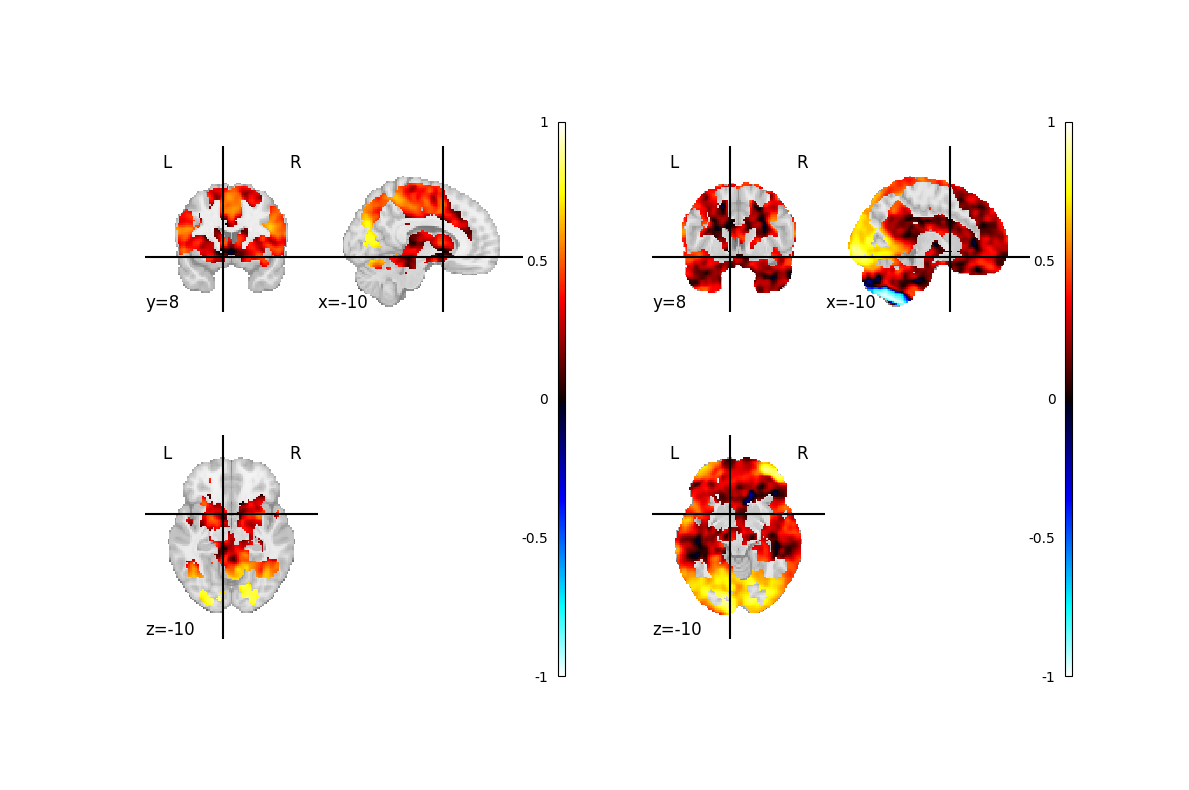

In [82]:
icc_maps = [icc_supra_imgs, icc_sub_imgs]
icc_img = 24

plot_top_maps(imgs=icc_maps, img_index=icc_img,
              coordinates=(-10, 8, -10), vmax=1)

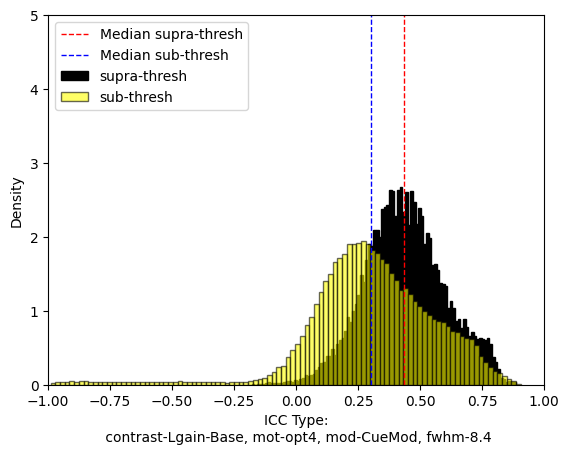

In [85]:
model_name = df_icc_supra.loc[icc_img, ['con','motion', 'model', 'fwhm']].values
xlab = f'ICC Type:\n {", ".join(model_name)}'

plot_dist_imgs(supra_imgs=icc_supra_imgs, sub_imgs=icc_sub_imgs, img_index=icc_img,
               mask_supra=mask_supra, mask_sub=mask_sub,
               bins=100, ylim=(0,5),xlim=(-1,1),dec_round=3,
               xlab=xlab)

In [84]:
# match to top session test-retest model
conditions = (
    (df_icc_supra["mask"] == "mask-wilson-supra") &
    (df_icc_supra["con"] == "contrast-Lgain-Base") &
    #(df_icc_supra["motion"] == "mot-opt3") &
    (df_icc_supra["model"] == "mod-AntMod") 
    #(df_icc_supra["fwhm"] == "fwhm-8.4")
)

df_icc_supra[conditions].sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
124,mask-wilson-supra,contrast-Lgain-Base,mot-opt1,mod-AntMod,fwhm-8.4,0.140
123,mask-wilson-supra,contrast-Lgain-Base,mot-opt1,mod-AntMod,fwhm-7.2,0.137
122,mask-wilson-supra,contrast-Lgain-Base,mot-opt1,mod-AntMod,fwhm-6.0,0.132
121,mask-wilson-supra,contrast-Lgain-Base,mot-opt1,mod-AntMod,fwhm-4.8,0.125
19,mask-wilson-supra,contrast-Lgain-Base,mot-opt4,mod-AntMod,fwhm-8.4,0.120
18,mask-wilson-supra,contrast-Lgain-Base,mot-opt4,mod-AntMod,fwhm-7.2,0.114
120,mask-wilson-supra,contrast-Lgain-Base,mot-opt1,mod-AntMod,fwhm-3.6,0.113
17,mask-wilson-supra,contrast-Lgain-Base,mot-opt4,mod-AntMod,fwhm-6.0,0.105
4,mask-wilson-supra,contrast-Lgain-Base,mot-opt3,mod-AntMod,fwhm-8.4,0.100
3,mask-wilson-supra,contrast-Lgain-Base,mot-opt3,mod-AntMod,fwhm-7.2,0.096


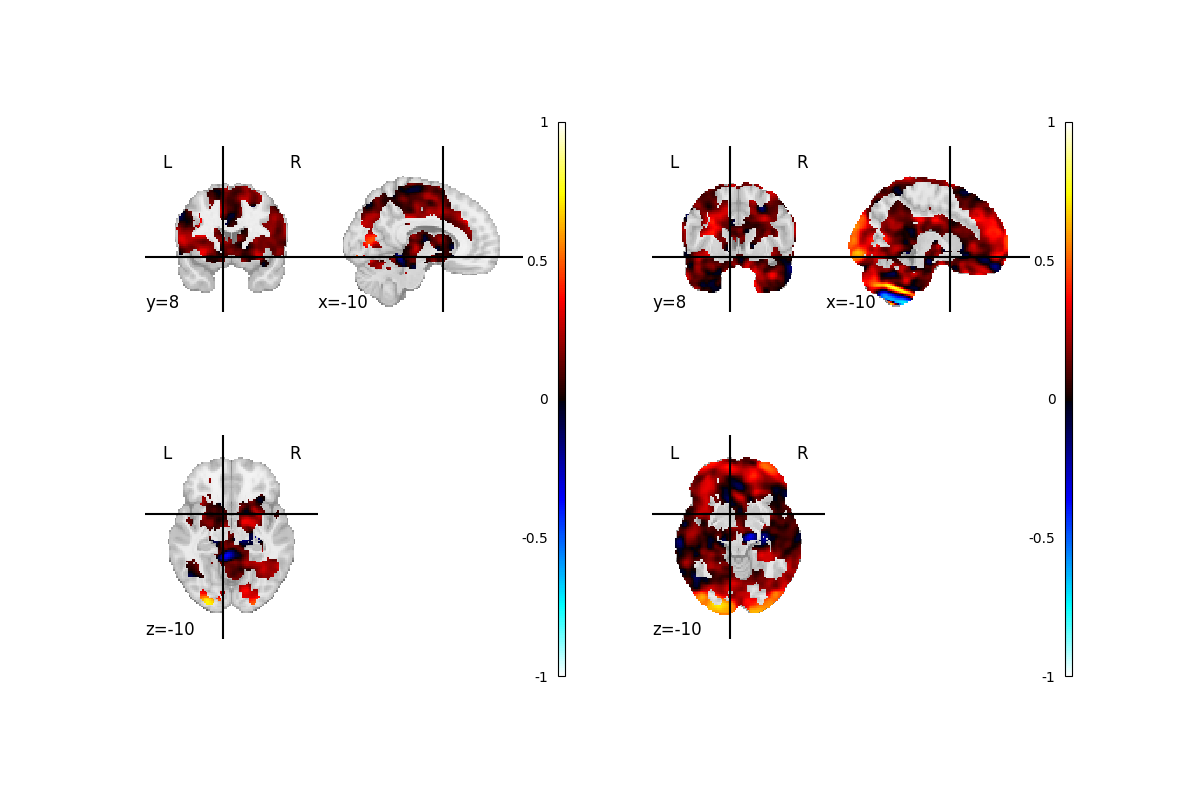

In [86]:
icc_maps = [icc_supra_imgs, icc_sub_imgs]
icc_img = 124

plot_top_maps(imgs=icc_maps,
              img_index=icc_img,
              coordinates=(-10, 8, -10), vmax=1)

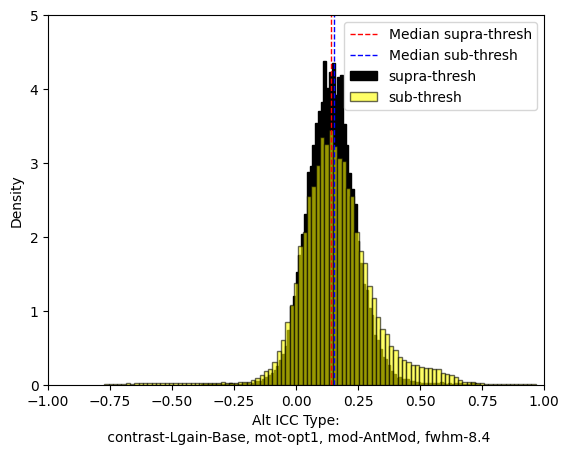

In [88]:
model_name = df_icc_supra.loc[icc_img, ['con', 'motion', 'model', 'fwhm']].values
xlab = f'Alt ICC Type:\n {", ".join(model_name)}'

plot_dist_imgs(supra_imgs=icc_supra_imgs, sub_imgs=icc_sub_imgs, img_index=icc_img,
               mask_supra=mask_supra, mask_sub=mask_sub,
               bins=100, ylim=(0,5),xlim=(-1,1),dec_round=3,
               xlab=xlab)

### sort MSBS by median est + img of highest

In [89]:
df_bs_supra.sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
185,mask-wilson-supra,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-3.6,2.925
125,mask-wilson-supra,contrast-Lgain-Base,mot-opt1,mod-CueMod,fwhm-3.6,2.795
186,mask-wilson-supra,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-4.8,2.274
200,mask-wilson-supra,contrast-Sgain-Base,mot-opt2,mod-CueMod,fwhm-3.6,2.255
140,mask-wilson-supra,contrast-Lgain-Base,mot-opt2,mod-CueMod,fwhm-3.6,2.175
...,...,...,...,...,...,...
49,mask-wilson-supra,contrast-Lgain-Neut,mot-opt4,mod-AntMod,fwhm-8.4,0.082
93,mask-wilson-supra,contrast-Sgain-Neut,mot-opt3,mod-AntMod,fwhm-7.2,0.080
108,mask-wilson-supra,contrast-Sgain-Neut,mot-opt4,mod-AntMod,fwhm-7.2,0.075
94,mask-wilson-supra,contrast-Sgain-Neut,mot-opt3,mod-AntMod,fwhm-8.4,0.067


In [90]:
df_bs_sub.sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
185,mask-wilson-sub,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-3.6,4.174
125,mask-wilson-sub,contrast-Lgain-Base,mot-opt1,mod-CueMod,fwhm-3.6,4.095
186,mask-wilson-sub,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-4.8,3.149
140,mask-wilson-sub,contrast-Lgain-Base,mot-opt2,mod-CueMod,fwhm-3.6,3.118
200,mask-wilson-sub,contrast-Sgain-Base,mot-opt2,mod-CueMod,fwhm-3.6,3.116
...,...,...,...,...,...,...
93,mask-wilson-sub,contrast-Sgain-Neut,mot-opt3,mod-AntMod,fwhm-7.2,0.117
49,mask-wilson-sub,contrast-Lgain-Neut,mot-opt4,mod-AntMod,fwhm-8.4,0.113
108,mask-wilson-sub,contrast-Sgain-Neut,mot-opt4,mod-AntMod,fwhm-7.2,0.107
94,mask-wilson-sub,contrast-Sgain-Neut,mot-opt3,mod-AntMod,fwhm-8.4,0.100


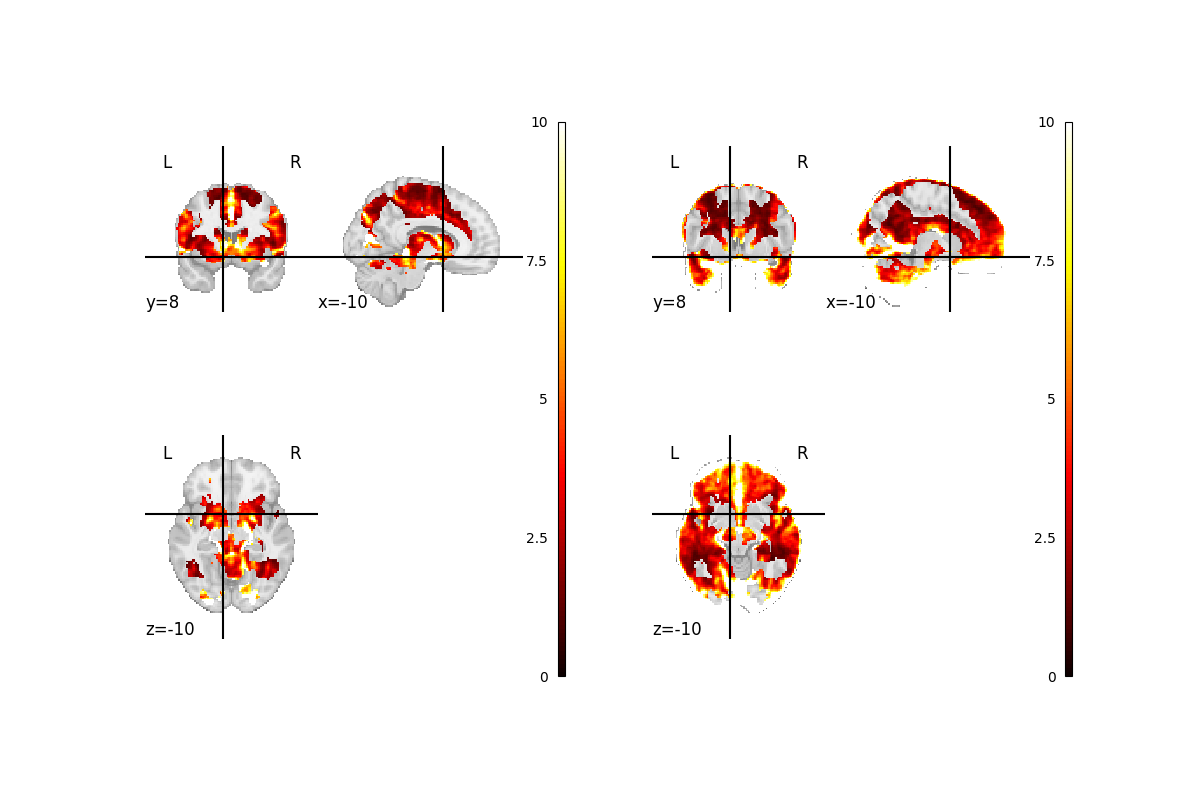

In [93]:
bs_maps = [bs_supra_imgs, bs_sub_imgs]
bs_img = 185

plot_top_maps(imgs=bs_maps,
              img_index=bs_img,
              coordinates=(-10, 8, -10), 
              vmax=10)

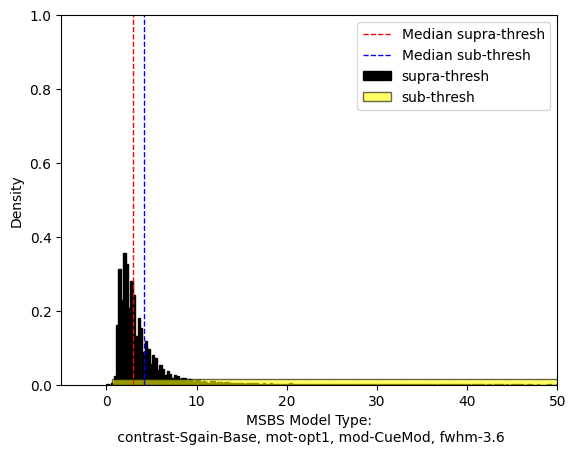

In [94]:
model_name = df_bs_supra.loc[bs_img, ['con', 'motion','model', 'fwhm']].values
xlab = f'MSBS Model Type:\n {", ".join(model_name)}'

plot_dist_imgs(supra_imgs=bs_supra_imgs, sub_imgs=bs_sub_imgs, img_index=bs_img,
               mask_supra=mask_supra, mask_sub=mask_sub,
               bins=500,ylim=(0,1),xlim=(-5,50),
               xlab=xlab)

### sort MSWS by median est + img of highest

In [95]:
df_ws_supra.sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
185,mask-wilson-supra,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-3.6,1.636
125,mask-wilson-supra,contrast-Lgain-Base,mot-opt1,mod-CueMod,fwhm-3.6,1.558
155,mask-wilson-supra,contrast-Lgain-Neut,mot-opt1,mod-CueMod,fwhm-3.6,1.425
190,mask-wilson-supra,contrast-Sgain-Base,mot-opt1,mod-FixMod,fwhm-3.6,1.296
215,mask-wilson-supra,contrast-Sgain-Neut,mot-opt1,mod-CueMod,fwhm-3.6,1.288
...,...,...,...,...,...,...
34,mask-wilson-supra,contrast-Lgain-Neut,mot-opt3,mod-AntMod,fwhm-8.4,0.068
108,mask-wilson-supra,contrast-Sgain-Neut,mot-opt4,mod-AntMod,fwhm-7.2,0.067
49,mask-wilson-supra,contrast-Lgain-Neut,mot-opt4,mod-AntMod,fwhm-8.4,0.062
94,mask-wilson-supra,contrast-Sgain-Neut,mot-opt3,mod-AntMod,fwhm-8.4,0.061


In [96]:
df_ws_sub.sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
185,mask-wilson-sub,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-3.6,2.386
125,mask-wilson-sub,contrast-Lgain-Base,mot-opt1,mod-CueMod,fwhm-3.6,2.378
155,mask-wilson-sub,contrast-Lgain-Neut,mot-opt1,mod-CueMod,fwhm-3.6,2.247
215,mask-wilson-sub,contrast-Sgain-Neut,mot-opt1,mod-CueMod,fwhm-3.6,2.061
190,mask-wilson-sub,contrast-Sgain-Base,mot-opt1,mod-FixMod,fwhm-3.6,2.017
...,...,...,...,...,...,...
108,mask-wilson-sub,contrast-Sgain-Neut,mot-opt4,mod-AntMod,fwhm-7.2,0.099
34,mask-wilson-sub,contrast-Lgain-Neut,mot-opt3,mod-AntMod,fwhm-8.4,0.098
94,mask-wilson-sub,contrast-Sgain-Neut,mot-opt3,mod-AntMod,fwhm-8.4,0.094
49,mask-wilson-sub,contrast-Lgain-Neut,mot-opt4,mod-AntMod,fwhm-8.4,0.088


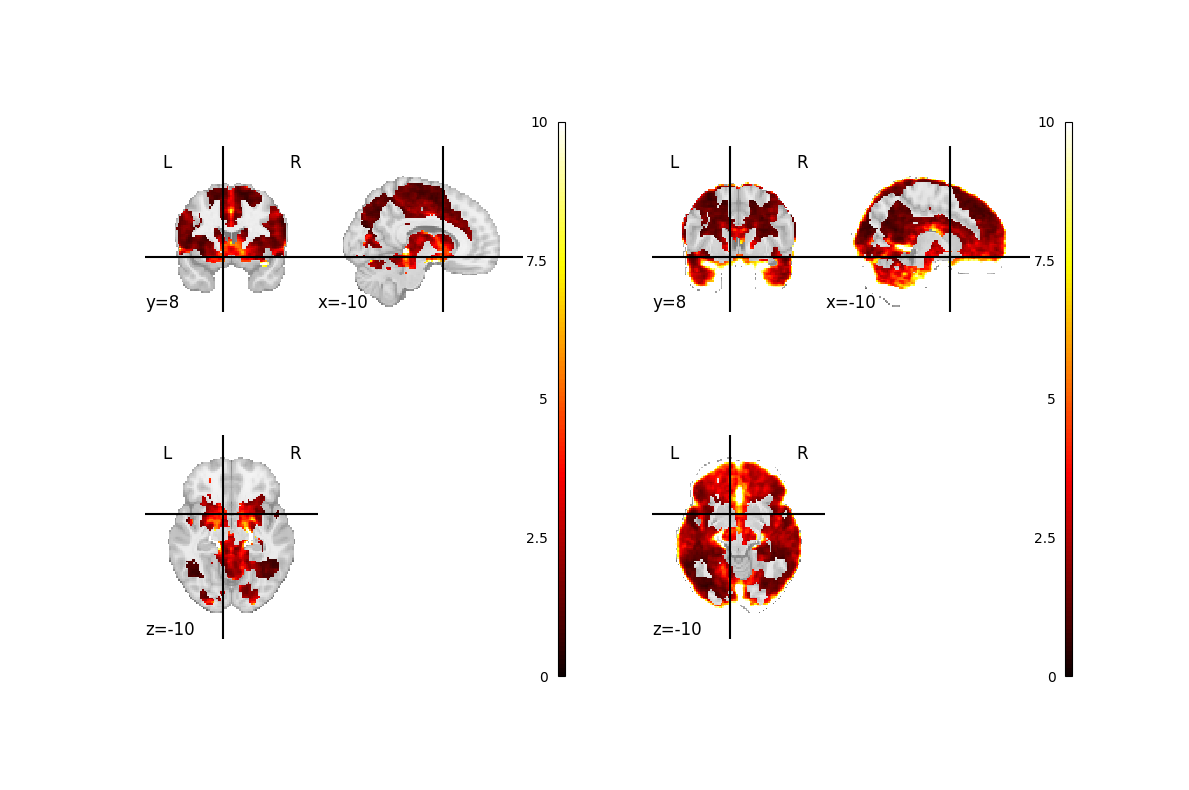

In [98]:
ws_maps = [ws_supra_imgs, ws_sub_imgs]
ws_img = 185

plot_top_maps(imgs=ws_maps,
              img_index=ws_img,
              coordinates=(-10, 8, -10), vmax=10)

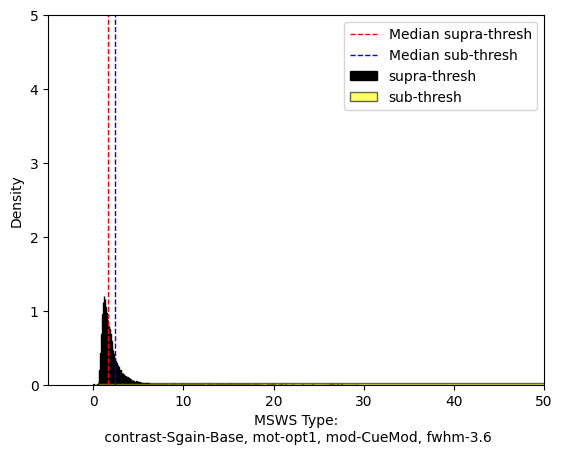

In [99]:
model_name = df_ws_supra.loc[ws_img, ['con', 'motion','model', 'fwhm']].values
xlab = f'MSWS Type:\n {", ".join(model_name)}'

plot_dist_imgs(supra_imgs=ws_supra_imgs, sub_imgs=ws_sub_imgs, img_index=ws_img,
               mask_supra=mask_supra, mask_sub=mask_sub,
               bins=500,ylim=(0,5),xlim=(-5,50),
               xlab=xlab)

# Residual Variance ~ ICC / MSWS / Cohens D

In [12]:
first_path = f'{out_dir}/firstlvl'
ses1_out = f'{group_out}/abcd_run'
ses2_out = f'{group_out}/abcd_run'
ses_out = f'{group_out}/ses_residvar'
con_opts = ['Lgain-Neut','Lgain-Base','Sgain-Neut','Sgain-Base']
model_opts = ['CueMod','AntMod','FixMod']
task = 'mid'
fwhm = 'fwhm-6.0'
n = 

if not os.path.exists(ses_out):
    os.makedirs(ses_out)

In [11]:
# dont re-run if already ran
for con in con_opts:
    for mod in model_opts:    
        resid_ses1_imgs = glob(f'{first_path}/ses-1/**/*_ses-1_task-{task}_run-0*_contrast-{con}_mask-mni152_mot-opt1_mod-{mod}_{fwhm}_stat-residvar.nii.gz')    
        resid_ses2_imgs = glob(f'{first_path}/ses-2/**/*_ses-2_task-{task}_run-0*_contrast-{con}_mask-mni152_mot-opt1_mod-{mod}_{fwhm}_stat-residvar.nii.gz')      

        ses1_mean, ses1_sd = mean_sd_img(resid_ses1_imgs)
        ses2_mean, ses2_sd = mean_sd_img(resid_ses1_imgs)
        ses_mean, ses_sd = mean_sd_img([ses1_mean,ses2_mean])
        
        ses1_name = f'{ses1_out}/subs-{n}_ses-1_task-{task}_type-session_contrast-{con}_mask-mni152_mot-opt1_mod-{mod}_{fwhm}_stat-residvar.nii.gz'
        ses2_name = f'{ses2_out}/subs-{n}_ses-2_task-{task}_type-session_contrast-{con}_mask-mni152_mot-opt1_mod-{mod}_{fwhm}_stat-residvar.nii.gz'
        ses_name = f'{ses_out}/subs-{n}_task-{task}_contrast-{con}_mask-mni152_mot-opt1_mod-{mod}_{fwhm}_stat-residvar.nii.gz'

        nib.save(ses1_mean, ses1_name)
        nib.save(ses2_mean, ses2_name)
        nib.save(ses_mean, ses_name)


KeyboardInterrupt: 

In [13]:
con = 'Lgain-Neut'
ant_mod = f'{ses_out}/subs-{n}_task-{task}_contrast-{con}_mask-mni152_mot-opt1_mod-AntMod_{fwhm}_stat-residvar.nii.gz'
fix_mod = f'{ses_out}/subs-{n}_task-{task}_contrast-{con}_mask-mni152_mot-opt1_mod-FixMod_{fwhm}_stat-residvar.nii.gz'
cue_mod = f'{ses_out}/subs-{n}_task-{task}_contrast-{con}_mask-mni152_mot-opt1_mod-CueMod_{fwhm}_stat-residvar.nii.gz'


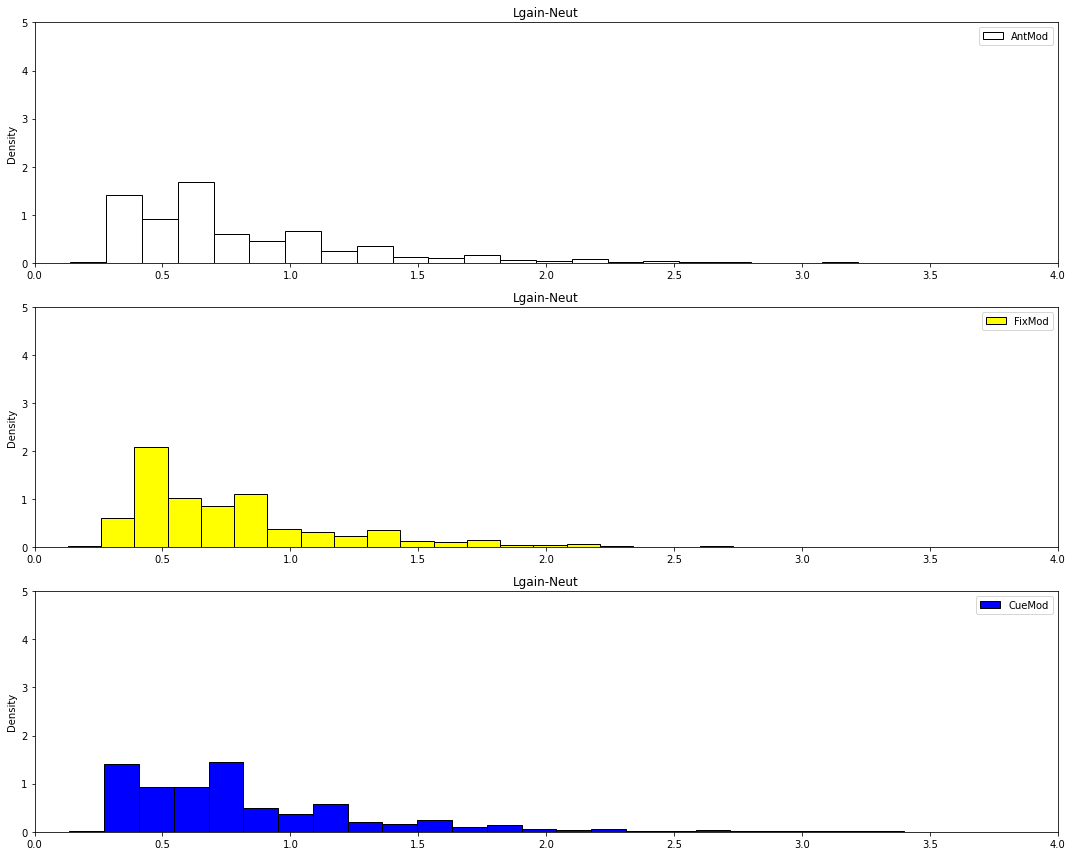

In [16]:
bins = 50

ant_supra = masking.apply_mask(ant_mod, mask_supra)
fix_supra = masking.apply_mask(fix_mod, mask_supra)
cue_supra = masking.apply_mask(cue_mod, mask_supra)
mod_maps = [ant_supra, fix_supra, cue_supra]
mod_names = ["AntMod","FixMod","CueMod"]
colors = ['white','yellow','blue']

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

for i, map_mod in enumerate(mod_maps):
    label = mod_names[i]
    color = colors[i]
    axes[i].hist(np.round(map_mod, decimals=1), bins=bins, edgecolor='black', color=color,
                 alpha=1, label=label, density=True)
    axes[i].legend() 
    axes[i].set_ylim(0,5)
    axes[i].set_xlim(0,4)
    axes[i].set_title(f"{con}")
    axes[i].set_ylabel('Density')
plt.tight_layout()
plt.show()


In [100]:
print(out_dir, group_out)

/scratch.global/mdemiden/analyses_reliability /scratch.global/mdemiden/analyses_reliability/group_lowmotion


In [17]:
mod_names = ["AntMod","FixMod","CueMod"]
con_names = ['Lgain-Neut','Lgain-Base','Sgain-Neut','Sgain-Base']
est_names = ['est', 'msbtwn', 'mswthn']
ses = 'baselineYear1Arm1'
first_path = f'{out_dir}/firstlvl'
ses1_out = f'{group_out}/abcd_session/baselineYear1Arm1'
ses2_out = f'{group_out}/abcd_session/2YearFollowUpArm1'


rho_list = []
for est in est_names:
    for mod in mod_names:
        for con in con_names:
            est_maps=glob(f'{out_dir}/icc_perm/run/*mask-wilson-supra_*contrast-{con}_mask-mni152_mot-opt4_mod-AntMod_{fwhm}_*stat-{est}.nii.gz')
            mod_img = f'{ses_out}/*_contrast-{con}_mask-mni152_mot-opt4_mod-{mod}_{fwhm}_stat-residvar.nii.gz'
            grp_img = f'{ses1_out}/*_task-{task}_type-session_contrast-{con}_mask-mni152_mot-opt4_mod-{mod}_{fwhm}_stat-cohensd.nii.gz'
            rho_icc = similarity.image_similarity(imgfile1=est_maps[0], imgfile2=mod_img, mask=mask_supra, similarity_type = 'spearman')
            rho_icccohens = similarity.image_similarity(imgfile1=est_maps[0], imgfile2=grp_img, mask=mask_supra, similarity_type = 'spearman')
            rho_residcohens = similarity.image_similarity(imgfile1=mod_img, imgfile2=grp_img, mask=mask_supra, similarity_type = 'spearman')
            rho_list.append({
                'Model': mod,
                'Contrast': con,
                'estimate': est,
                'icc_rho': rho_icc,
                'cohensicc_rho': rho_icccohens,
                'coehnsresid_rho': rho_residcohens
                
            })


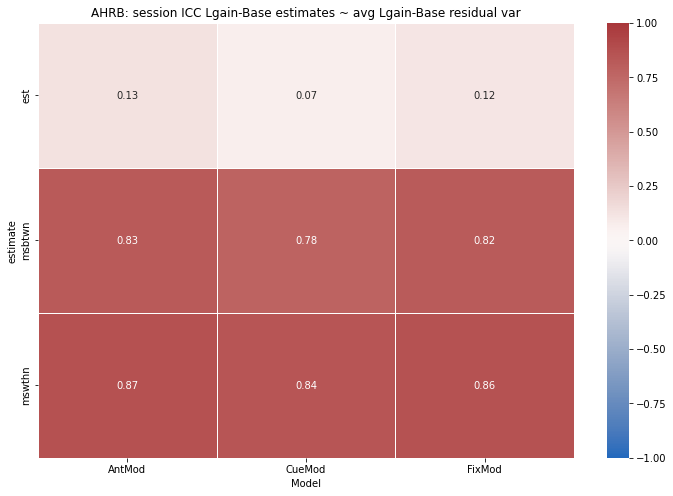

In [58]:
contrast = "Lgain-Base"
vmin = -1
vmax = 1 

rho_df = pd.DataFrame(rho_list)
heatmap_rho = rho_df[rho_df["Contrast"] == contrast].pivot_table(index='estimate', 
                                                                     columns=['Model'], values='icc_rho')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_rho, annot=True, cmap='vlag', linewidths=.5, fmt=".2f", vmin=vmin, vmax=vmax)
plt.title(f'{sample}: session ICC {contrast} estimates ~ avg {contrast} residual var')
plt.show()

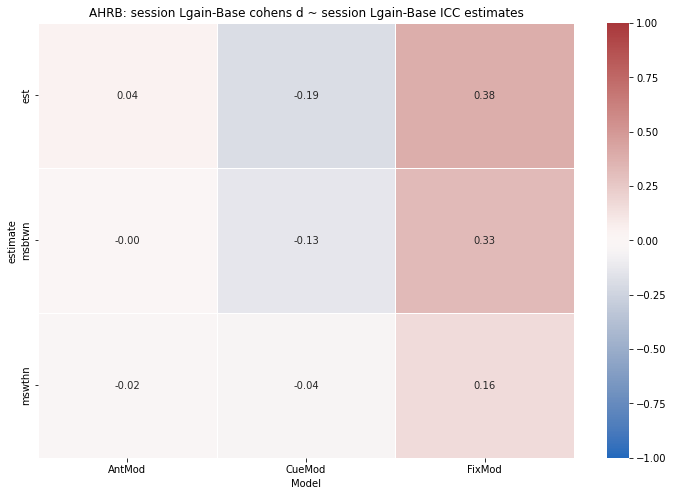

In [59]:
rho_df = pd.DataFrame(rho_list)
heatmap_rho = rho_df[rho_df["Contrast"] == contrast].pivot_table(index='estimate', 
                                                                     columns=['Model'], values='cohensicc_rho')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_rho, annot=True, cmap='vlag', linewidths=.5, fmt=".2f", vmin=vmin, vmax=vmax)
plt.title(f'{sample}: session {contrast} cohens d ~ session {contrast} ICC estimates')
plt.show()

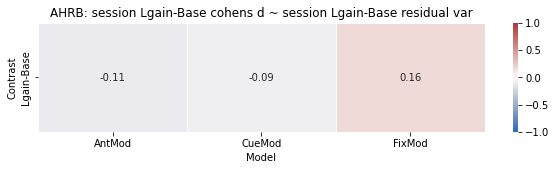

In [60]:
rho_df = pd.DataFrame(rho_list)
heatmap_rho = rho_df[rho_df["Contrast"] == contrast].pivot_table(index='Contrast', 
                                                                 columns=['Model'], values='coehnsresid_rho')
plt.figure(figsize=(10, 2))
sns.heatmap(heatmap_rho, annot=True, cmap='vlag', linewidths=.5, fmt=".2f", vmin=vmin, vmax=vmax)
plt.title(f'{sample}: session {contrast} cohens d ~ session {contrast} residual var')
plt.show()

In [ ]:
rho_list = []
for est in est_names:
    for mod in mod_names:
        for con in con_names:
            est_maps=glob(f'{out_dir}/icc_mods/run/wilson-supra/*contrast-{con}_mask-mni152_mot-opt1_mod-AntMod_{fwhm}_*stat-{est}.nii.gz')
            mod_img = f'{ses1_out}/subs-{n}_{ses}_task-{task}_type-session_contrast-{con}_mask-mni152_mot-opt1_mod-{mod}_{fwhm}_stat-residvar.nii.gz'
            rho_maps = similarity.image_similarity(imgfile1=est_maps[0], imgfile2=mod_img, mask=mask_supra, similarity_type = 'spearman')
            rho_list.append({
            'Model': mod,
            'Contrast': con,
            'estimate': est,
            'rho': rho_maps
        })

In [ ]:
rho_df = pd.DataFrame(rho_list)
heatmap_rho = rho_df.pivot_table(index='Contrast', columns=['estimate', 'Model'], values='rho')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_rho, annot=True, cmap='magma', linewidths=.5, fmt=".2f")
plt.title(f'{sample}: Heatmap for run est ~ avg residvar')
plt.show()

# Group-wise similarity

## Jaccards & spearman similarity

As described in the registered report:

*"Jaccard similarity coefficient is sensitive to thresholding and sample size (Bennett & Miller, 2010), in Aim 1 an equal sample size (e.g., N ~ 60) is chosen for each study to compare how the similarity between sessions varies across studies. For all 360 pipelines, a group-level (average) activation map is estimated for each session. In the case of the Jaccard coefficient, the group maps are thresholded at p < .001. In the case of the Spearman coefficient, the group maps are masked using a suprathreshold task-positive map from NeuroVault. Then, the paths for the pipelines and sessions are called using the pairwise_similarity within the similarity.py script. The resulting coefficients report the similarity between analytic pipelines and sessions for each study. For each study, the coefficients are plotted to reflect the distribution and range of coefficients. Both Jaccards and Spearman correlation are reported separately. Like Aim 1 & Aim 2, two HLMs are used to regress the Jaccard coefficients and Spearman correlation on the [four] analytic decisions nested within study. Multiple comparisons corrections are applied using the Tukey adjustment."*

In [102]:
contrasts = [
    'Lgain-Neut', 'Sgain-Neut',
    'Lgain-Base', 'Sgain-Base'
]

# Model permutations
if sample in ['abcd', 'AHRB']:
    voxel = 2.4
    opts = np.array([1.5,  2, 2.5, 3, 3.5])
    fwhm_opt = list(np.round(voxel * opts, 1))
elif sample in 'MLS':
    voxel = 4
    inh_smooth_weight = .50
    opts = np.array([1.5, 2, 2.5, 3, 3.5])*inh_smooth_weight
    fwhm_opt = list(np.round(voxel * opts, 1))

# only including 4; opt 5 is opt3 + subj mFD < .9 & opt6 is opt4 + subj mFD < .9. 
motion_opt = ["opt1", "opt2", "opt3", "opt4"]
modtype_opt = ["CueMod", "AntMod", "FixMod"]

permutation_list = list(product(contrasts, fwhm_opt, motion_opt, modtype_opt))

In [108]:
threshold = .4 # mod since t -> d transform
similar_list = []
mask_lab = 'wilson-supra'
n = 0
for con, fwhm, motion, model in permutation_list:
    n = n + 1
    print(f'Running {n} out of {len(permutation_list)}')
    # jaccard/ spearman similarity between session 1 and session 2
    img1 = f'{group_out}/ses-{ses}/{calc_type}/*type-{calc_type}01_contrast-{con}_mask-mni152_mot-{motion}_mod-{model}_fwhm-{fwhm}_stat-cohensd.nii.gz'
    img2 = f'{group_out}/ses-{ses}/{calc_type}/*type-{calc_type}02_contrast-{con}_mask-mni152_mot-{motion}_mod-{model}_fwhm-{fwhm}_stat-cohensd.nii.gz'
    jaccard = similarity.image_similarity(imgfile1=img1, imgfile2=img2, thresh = threshold, similarity_type = 'jaccard')
    spearman = similarity.image_similarity(imgfile1=img1, imgfile2=img2, mask=mask_supra, similarity_type = 'spearman')
    
    # spearman rho between session ICC + sess 1 & sess 2 cohens d
    ses_icc = f'{icc_est}/{mask_lab}/*_contrast-{con}_mask-mni152_mot-{motion}_mod-{model}_fwhm-{fwhm}*stat-est.nii.gz'
    run1 = f'{group_out}/ses-{ses}/{calc_type}/*type-{calc_type}01_contrast-{con}_mask-mni152_mot-{motion}_mod-{model}_fwhm-{fwhm}_stat-cohensd.nii.gz'
    run2 = f'{group_out}/ses-{ses}/{calc_type}/*type-{calc_type}02_contrast-{con}_mask-mni152_mot-{motion}_mod-{model}_fwhm-{fwhm}_stat-cohensd.nii.gz'
    run1_spear = similarity.image_similarity(imgfile1=ses_icc, imgfile2=run1, mask=mask_supra, similarity_type = 'spearman')
    run2_spear = similarity.image_similarity(imgfile1=ses_icc, imgfile2=run2, mask=mask_supra, similarity_type = 'spearman')


    similar_list.append({
        'con': con,
        'fwhm': fwhm,
        'motion': motion,
        'model': model,
        'jaccard': jaccard,
        'spearman': spearman,
        'run1_icc_cohensd': run1_spear,
        'run2_icc_cohensd': run2_spear,
        
    })
 

Running 1 out of 240
Running 2 out of 240
Running 3 out of 240
Running 4 out of 240
Running 5 out of 240
Running 6 out of 240
Running 7 out of 240
Running 8 out of 240
Running 9 out of 240
Running 10 out of 240
Running 11 out of 240
Running 12 out of 240
Running 13 out of 240
Running 14 out of 240
Running 15 out of 240
Running 16 out of 240
Running 17 out of 240
Running 18 out of 240
Running 19 out of 240
Running 20 out of 240
Running 21 out of 240
Running 22 out of 240
Running 23 out of 240
Running 24 out of 240
Running 25 out of 240
Running 26 out of 240
Running 27 out of 240
Running 28 out of 240
Running 29 out of 240
Running 30 out of 240
Running 31 out of 240
Running 32 out of 240
Running 33 out of 240
Running 34 out of 240
Running 35 out of 240
Running 36 out of 240
Running 37 out of 240
Running 38 out of 240
Running 39 out of 240
Running 40 out of 240
Running 41 out of 240
Running 42 out of 240
Running 43 out of 240
Running 44 out of 240
Running 45 out of 240
Running 46 out of 2

In [123]:
similarity_df = pd.DataFrame(similar_list)
similarity_df.to_csv(out_similarity, sep='\t', index=False)

## Posthc, Session Group Map ~ Session ICC

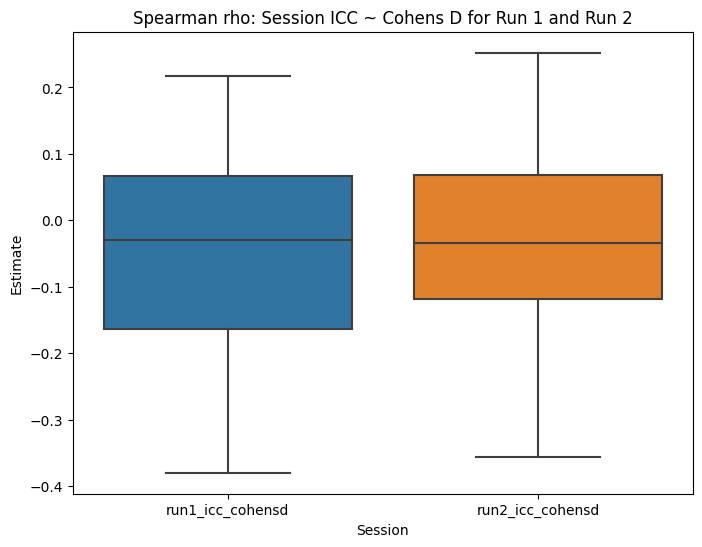

In [125]:
spear_sim_df = pd.DataFrame(similarity_df[['run1_icc_cohensd','run2_icc_cohensd']])
spear_sim_long = pd.melt(spear_sim_df, var_name="Session", value_name="SpearmanEstimate")

# Boxplot Spearman rho between Session 1 (or 2) Group Cohen's D map ~ Session ICC est. masked suprathresh
plt.figure(figsize=(8, 6))
sns.boxplot(x="Session", y="SpearmanEstimate", data=spear_sim_long)
plt.ylabel('Estimate')
plt.title('Spearman rho: Session ICC ~ Cohens D for Run 1 and Run 2')

# Show the plot
plt.show()